# Machine Learning Engineer Nanodegree
## Capstone Project - Street View House Numbers
Thomas Wieczorek
January 1st, 2017

## I. Definition
_(approx. 1-2 pages)_

### Project Overview
In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_

This capstone-project aims to solve the problem to correctly classify housenumber from Street View images. A rule-based approach ("Look for a certain color or pattern...) is not very promising, because the house numbers are very heterogeneously. They come in all colors, different fonts, sometimes they are even one underneath the other.  

![image alt >](res/Street_View.png)
<center>_1. Example of Google Street View in Berlin_</center>
![image alt >](res/Street_View_close.png)
<center>_2. Close up of House Number_</center>

The dataset was taken from Stanford University, which they describe as follows: _SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images._ (from http://ufldl.stanford.edu/housenumbers/)


To solve this Computer Vision problem, the domain of Machine Learning is advisable. Especially Deep Learning has been very successful for solving Computer Vision problems like these in the latest years. 


### Problem Statement
In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_

The problem statement is to identify which house number is shown in the picture. The images from the SVHN have been resized to a fixed resolution of 32-by-32 pixels. The file type is .mat. In addition to the images, we have the correct labels of every image.

However, if there are more than one number, the images are cropped, so that every number is in the middle of the picture. So the classifier only has to classify one digit.

![image alt >](res/Classification_Examples.png)
<center>_3. Example of correct predictions._</center>

![image alt >](res/Example_Cropping.png)
<center>_4. Example of Cropping a 4-digit house number._</center>

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_
<br><br>

The metrics used for this project were **Accuracy** and the **Confusion Matrix**. The Formula for the **Accuracy** is:

\begin{align}
{Accuracy} & = \frac{tp+tn}{tp+tn+fp+fn} \\\\
{tp} & : {True Positive} \\
{tn} & : {True Negative} \\
{fp} & : {False Positive} \\
{fn} & : {False Negative} \\ 
\end{align}
<br><br>
For my research, I plotted the Accuracy of the **Training Data**, as well as of the **Validation Data** to prevent [Overfitting](https://www.wikiwand.com/en/Overfitting). 

![image alt >](res/Accuracy.png)
<center>_4. Accuracy of Train-Data and Validation-Data._</center>
<br>
If the validation line would be declining while the training line still increasing, it is a very good sign to detect Overfitting. See this figure:

![image alt >](res/Overfitting.png)
<center>_5. Overfitting example_</center>
<br><br>

In addition to this, I always used a Confusion Matrix. This helps to identify problems with certain classes (for example the number 3 always get mixed up with 8, because of the similarity). 

![image alt >](res/ConfusionMatrix.png)
<center>_6. Confusion Matrix_</center>
<br><br>

## II. Analysis
_(approx. 2-4 pages)_

### Imports

In [1]:
import cv2

In [2]:
from urllib.request import urlretrieve
import hashlib
import os
from zipfile import ZipFile
import tarfile

import scipy.io as sio

import matplotlib.pyplot as plt

import os
from scipy.misc import imresize

import random
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

import pandas as pd
from IPython.display import display, HTML

import itertools

# Visualizations will be shown in the notebook.
%matplotlib inline

### Preperations

In [3]:
DEBUG_MODUS = False
LEARN_MODUS = True
DEVICE_NAME = "/cpu:0" #For Training with GPU change to: "/gpu:0"

train_file = "data/train_32x32.mat"
test_file = "data/test_32x32.mat"

### Download

In [4]:
# Based on https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/lab.ipynb
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('http://ufldl.stanford.edu/housenumbers/train_32x32.mat', train_file)
download('http://ufldl.stanford.edu/housenumbers/test_32x32.mat', test_file)

# Make sure the files aren't corrupted
assert hashlib.md5(open(train_file, 'rb').read()).hexdigest() == 'e26dedcc434d2e4c54c9b2d4a06d8373',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open(test_file, 'rb').read()).hexdigest() == 'eb5a983be6a315427106f1b164d9cef3',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

All files downloaded.


### Extract

In [36]:
#************** Extract **************#

train_dataset = sio.loadmat(train_file)
test_dataset = sio.loadmat(test_file)

X_train, y_train = train_dataset['X'], train_dataset['y']
X_test, y_test = test_dataset['X'], test_dataset['y']

#*********** Preprocessing ***********#

#Put the images from the last to the first index
X_train = np.transpose(X_train, (3,0,1,2))
X_test = np.transpose(X_test, (3,0,1,2))

#Reshape from (xxx,1) to (xxx)
y_train = np.reshape(y_train, (y_train.shape[0]))
y_test = np.reshape(y_test, (y_test.shape[0]))

# House Numbers with '0' were marked as '10'. 
# Changing every 10 to 0
y_train[np.where(y_train==10)] = 0
y_test[np.where(y_test==10)] = 0



### Data Exploration
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

The data-sets have a shape of: (32, 32, 3, <batchsize>). The indices are (width, height, channels, batchsize). For easier usage in Tensorflow, I changed the shape to (<batchsize>, 32, 32, 3). 

X_train.shape: 	(73257, 32, 32, 3) <br>
y_train.shape: 	(73257,) <br>
X_test.shape:  	(26032, 32, 32, 3) <br>
y_test.shape:  	(26032,)<br>

Number of training examples =	 73257 <br>
Number of testing examples =	 26032 <br>
Image data shape =		         (32, 32, 3) <br>
Number of classes =		         10 

In [37]:
print("X_train.shape: \t{}".format(X_train.shape))
print("y_train.shape: \t{}".format(y_train.shape))
print("X_test.shape:  \t{}".format(X_test.shape))
print("y_test.shape:  \t{}".format(y_test.shape))

#Number of training examples
n_train = X_train.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#Shape of a house number image?
image_shape = X_train.shape[1:]

# Amount of unique classes/labels there are in the dataset.
n_classes = y_train.ptp() + 1 

print("\nNumber of training examples =\t", n_train)
print("Number of testing examples =\t", n_test)
print("Image data shape =\t\t", image_shape)
print("Number of classes =\t\t", n_classes)

X_train.shape: 	(73257, 32, 32, 3)
y_train.shape: 	(73257,)
X_test.shape:  	(26032, 32, 32, 3)
y_test.shape:  	(26032,)

Number of training examples =	 73257
Number of testing examples =	 26032
Image data shape =		 (32, 32, 3)
Number of classes =		 10


In [7]:
# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

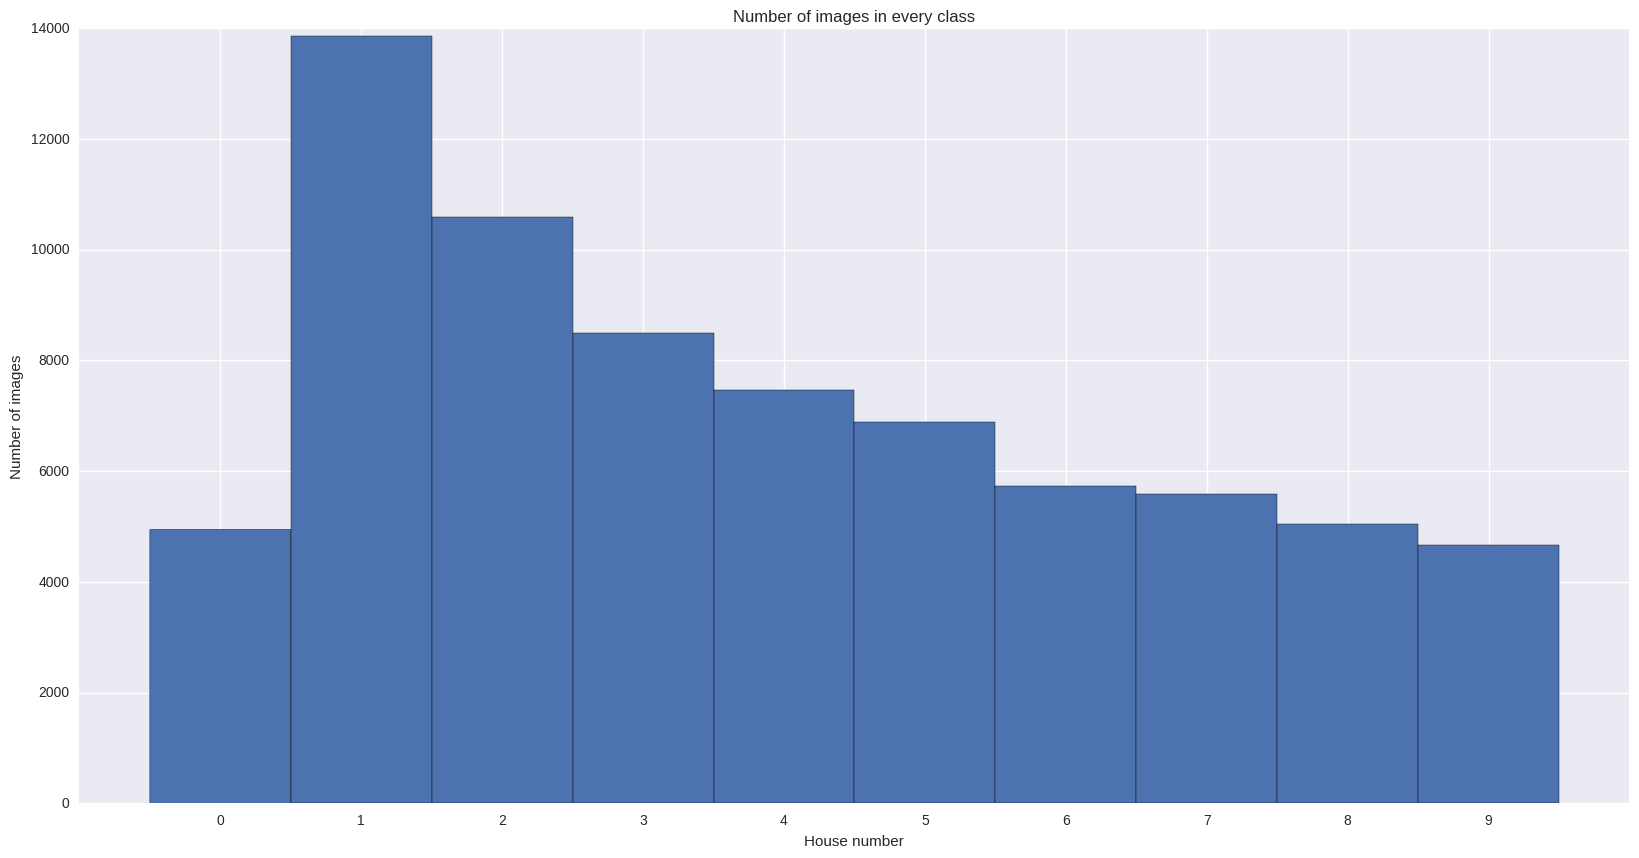

In [9]:
#Histogram of house number occurrences

plt.figure(figsize=(20,10))
plt.hist(y_train, np.arange(n_classes+1) - 0.5) #+1 and -0.5 is for centering labels
plt.xticks(range(n_classes))
plt.xlim([-1, n_classes])
plt.title("Number of images in every class")
plt.ylabel("Number of images")
plt.xlabel("House number")

plt.show()

https://www.wikiwand.com/en/Benford's_law

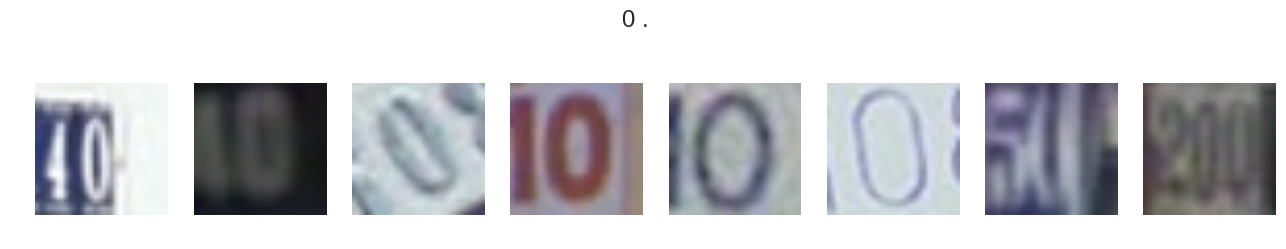

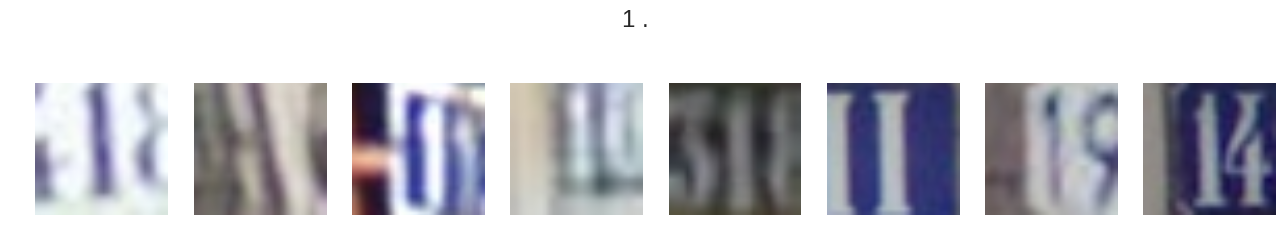

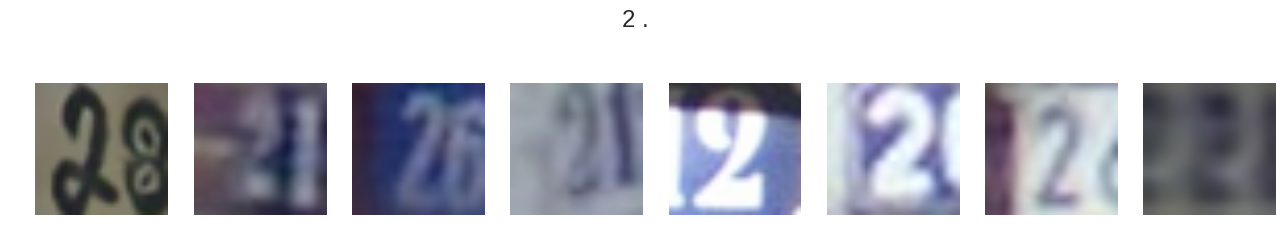

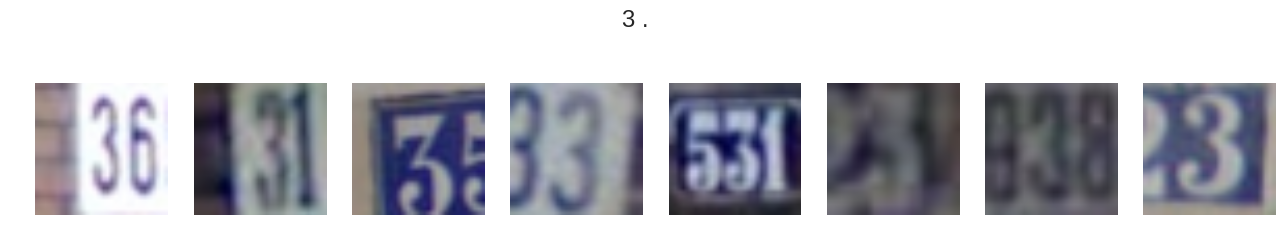

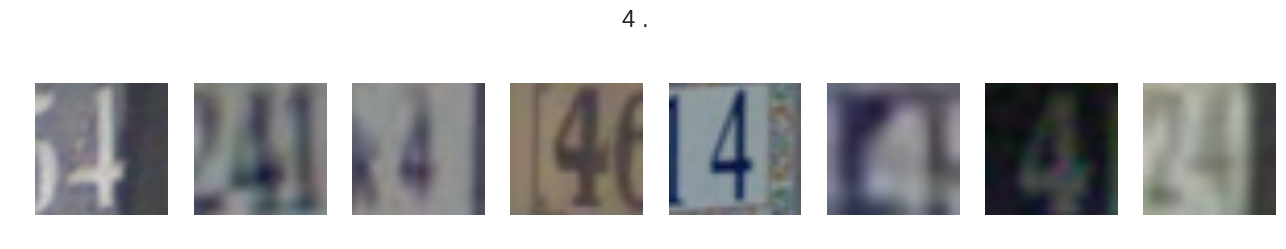

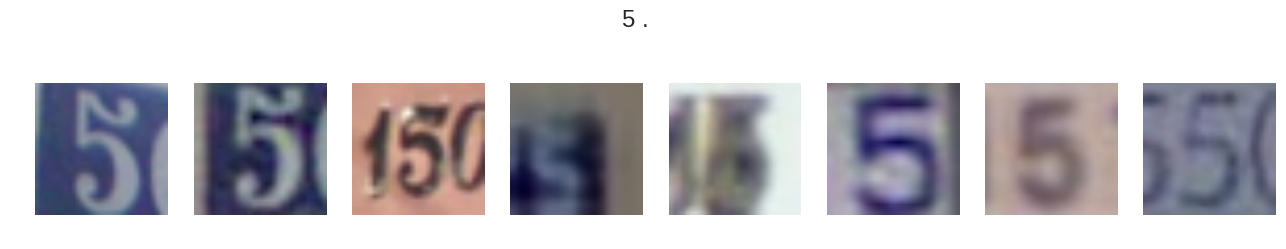

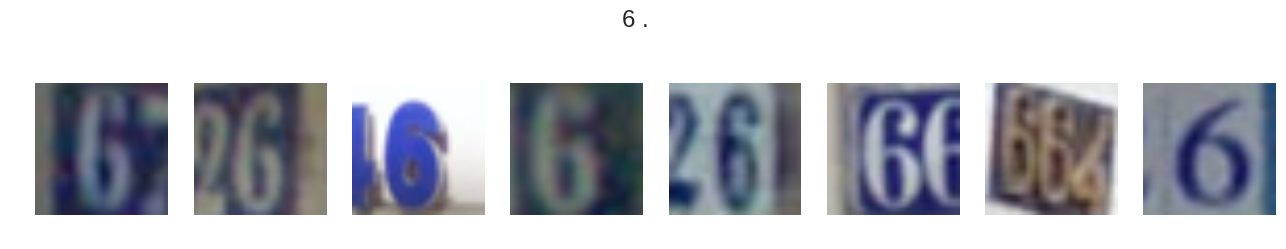

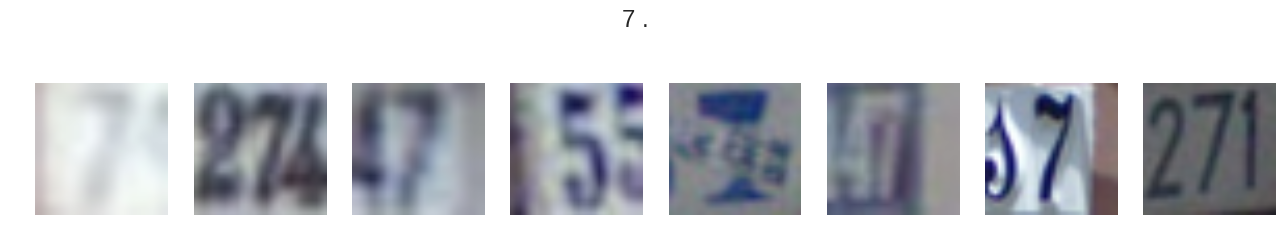

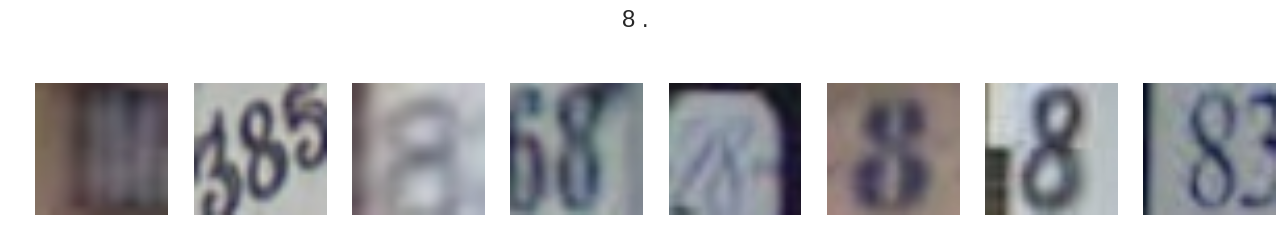

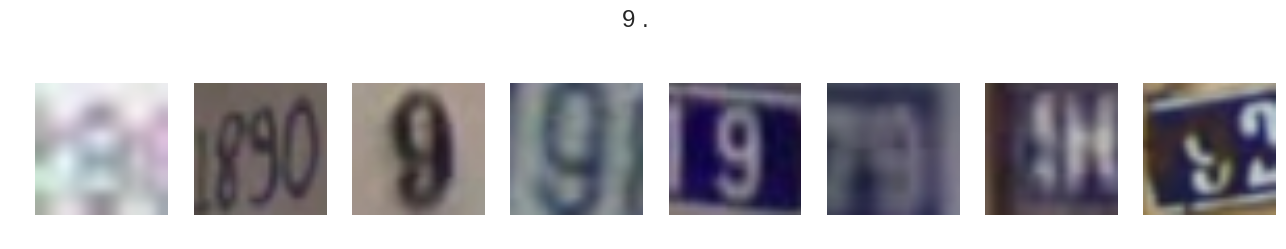

In [40]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

def visualize_class(classId, num_images = 8):
    """Display a few signs of a single class
    Keyword arguments:
    classID    -- Class ID of the sign
    num_images -- Number of images shown
    """
    
    examples_train = X_train[np.where(y_train==classId)[0]]
    # pick random index
    idx = np.random.choice(len(examples_train), num_images)
    
    f, ax = plt.subplots(1, num_images, figsize=(16,3))
    f.suptitle("{} .".format(classId), fontsize='xx-large')
    
    for i in range(num_images):     
        ax[i].imshow(examples_train[idx[i]])
        ax[i].axis('off')

    plt.show()

for c in range(n_classes):
    if not DEBUG_MODUS:
        visualize_class(c)

Plot 5 images from the offset 22347


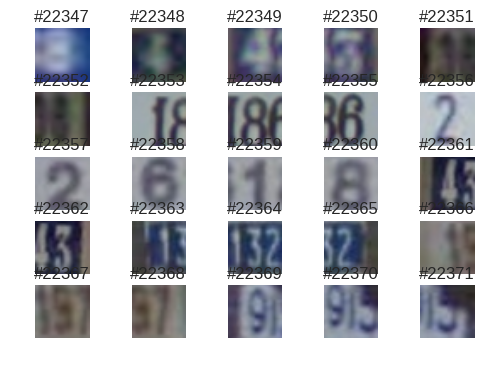

Plot 5 *random* images


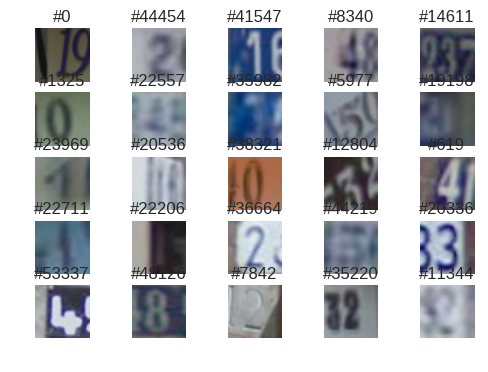

In [44]:
random.seed(datetime.now())

def plot_images(offset = 0, num_images = 5):
    """Plot signs from the offset."""
    print("Plot {} images from the offset {}".format(num_images, offset))
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset+i+(a*num_images)
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            
    plt.show()

def plot_random_train(offset = 0, num_images = 5):
    """Plot random signs."""
    print("Plot {} *random* images".format(num_images, offset))
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            offset = random.randint(0,len(X_train))
            
    plt.show()

if not DEBUG_MODUS:
    plot_images(offset=22347)
    plot_random_train()
    
    

There were no abnormalities or characteristics found, however some images are very blurry, and it is even hard for humans to identify them.
![image alt >](res/Blurry.png)
<center>_6. Example of Blurry Image_</center>


### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_



There are 10 classes with the digits from 0-9. Originally, the zeros were labeled as '10'. To remove any irritations, I changed it back to '0'.

The classes are not distributed equally. The distribution seems to follow [Benford's Law](https://www.wikiwand.com/en/Benford's_law). 


![image alt >](res/Labels_Histogram.png)
<center>_Histogram of the labels_</center>

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_


For solving the classification problem I will use Deep Learning techniques, to be more precise: Convolutional Neural Networks (CNN). As architecture I will use [LeNET](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf), which achieves good results for computer vision classification problems.

![image alt >](res/lenet.png)
<center>_LeNet Architecture_</center>


As Optimizer, I will use the AdamOptimizer. To reduce Overfitting, I will use Dropout.

**Default Parameter:**
- Normalizing = Off
- AdamOptimizer with Learning Rate = 0.001
- EPOCHS = 10
- BATCH_SIZE = 50
- Dropout Rate = 0.5

### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_


# <font color='red'> //TODO</font> - Erweitern?

As described, I will use **Accuracy** of the validation set as benchmark. 

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_


For preprocessing, I used [Histogram equalization](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html). 

_Consider an image whose pixel values are confined to some specific range of values only. For eg, brighter image will have all pixels confined to high values. But a good image will have pixels from all regions of the image. So you need to stretch this histogram to either ends (as given in below image, from wikipedia) and that is what Histogram Equalization does (in simple words). This normally improves the contrast of the image._ (from http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html)

![image alt >](res/Histogram_Equalization.png)
<center>_6. Example of Blurry Image_</center>


In addition to that, I used [One Hot Encoding](https://www.wikiwand.com/en/One-hot) for the labels. The workings is well explained in this image:

![image alt >](res/OneHot.jpg)
<center>_6. Example of Blurry Image_</center>

As another way to prevent Overfitting, I splitted the training set into 2 seperate sets: Training and Validation set.<br>
Train size: 		(49082, 32, 32, 3) <br>
Validiation size: 	(24175, 32, 32, 3) <br>
Test size: 		(26032, 32, 32, 3)

In [11]:
def normalize_YUV(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB) 

# data preperation: normalize
if not is_features_normal:       
    ## Normalize Training Set
    for i, pic in enumerate(X_train):
        X_train[i] = normalize_YUV(X_train[i])

    ## Normalize Test Set
    for i, pic in enumerate(X_test):
        X_test[i] = normalize_YUV(X_test[i])
    
    #Only normalize once
    is_features_normal = True

### One Hot 

In [12]:
# One Hot Encoding

if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    
    #Only One Hot Encode once
    is_labels_encod = True

In [13]:
#Check if One-Hot Encoding works
print("y_train.shape: {}".format(y_train.shape))
for i in range(5):
    a=random.randint(0,n_train)
    print("index = {}\n{}".format(a, y_train[a]))
    
print("\n\ny_test.shape: {}".format(y_test.shape))
for i in range(5):
    a=random.randint(0,n_test)
    print("index = {}\n{}".format(a, y_test[a]))

y_train.shape: (73257, 10)
index = 69716
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
index = 71
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
index = 39382
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
index = 9764
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
index = 47470
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


y_test.shape: (26032, 10)
index = 20084
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
index = 18459
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
index = 21429
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
index = 18648
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
index = 20058
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [14]:
# One Hot to Classnumber
y_test_classes = np.argmax(y_test,1)

In [15]:
print(y_test_classes[:10])

[5 2 1 0 6 1 9 1 1 8]


###  Split in Train, Val and Test

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, stratify = y_train )

In [17]:
print("Train size: \t\t{}\nValidiation size: \t{}\nTest size: \t\t{}".format(
        X_train.shape, X_val.shape, X_test.shape))

Train size: 		(49082, 32, 32, 3)
Validiation size: 	(24175, 32, 32, 3)
Test size: 		(26032, 32, 32, 3)


### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_


# <font color='red'> //TODO</font> - Code als Erläuterung lassen?

In [18]:
EPOCHS = 10
BATCH_SIZE = 50

In [19]:
def LeNet(x, keep_prob):

    # 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal([5, 5, 3, 6], stddev = 0.01))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16),stddev = 0.01))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    conv2 = tf.nn.relu(conv2)

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')   

    # Flatten
    fc1 = flatten(conv2)
    # (5 * 5 * 16, 120)

    fc1_W = tf.Variable(tf.truncated_normal([400,120],stddev = 0.01))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    
    #Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, n_classes), stddev = 0.01))
    fc2_b = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc1, fc2_W) + fc2_b

In [20]:
with tf.device(DEVICE_NAME):
    # Data consists of 32x32x3 images
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))

    # Classify over 43 signs
    y = tf.placeholder(tf.float32, (None, n_classes))

    #Keep probability for Dropout
    keep_prob = tf.placeholder(tf.float32)

    #Call LeNet
    fc2 = LeNet(x, keep_prob)

    # Loss
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))

    # Optimizer: AdamOptimizer
    opt = tf.train.AdamOptimizer(learning_rate=0.0002)
    train_op = opt.minimize(loss_op)

    correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    predictions = tf.cast(tf.argmax(fc2,1), tf.int32)

In [21]:
def eval_data(X_data, y_data):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    # If dataset.num_examples is not divisible by BATCH_SIZE
    # the remainder will be discarded.
    # Ex: If BATCH_SIZE is 64 and training set has 55000 examples
    # steps_per_epoch = 55000 // 64 = 859
    # num_examples = 859 * 64 = 54976
    #
    # So in that case we go over 54976 examples instead of 55000.
    steps_per_epoch = len(X_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        batch_end = (step + 1) * BATCH_SIZE
        batch_x = X_data[batch_start:batch_end] 
        batch_y = y_data[batch_start:batch_end]
        
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
        
    return total_loss/num_examples, total_acc/num_examples


In [22]:
def prediction_in_batches(X_data):
    steps_per_epoch = len(X_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    preds = np.ndarray(shape=(len(X_data)), dtype=np.int32)
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        batch_end = (step + 1) * BATCH_SIZE
        batch_x = X_data[batch_start:batch_end] 
        
        preds[batch_start:batch_end] = sess.run(predictions, feed_dict={x: batch_x, keep_prob: 1.0})
    
    #Last part which is too small for BATCH_SIZE
    batch_x = X_data[batch_end+1:len(X_data)-1]
    if not len(batch_x)==0: 
        preds[batch_end+1:len(X_data)-1] = sess.run(predictions, feed_dict={x: batch_x, keep_prob: 1.0})
    return preds

In [24]:
#http://stackoverflow.com/questions/33759623/tensorflow-how-to-restore-a-previously-saved-model-python

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

if __name__ == '__main__':
    if LEARN_MODUS:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            steps_per_epoch = len(X_train) // BATCH_SIZE
            num_examples = steps_per_epoch * BATCH_SIZE

            # Train model
            for i in range(EPOCHS):
                for step in range(steps_per_epoch):
                    #Calculate next Batch
                    batch_start = step * BATCH_SIZE
                    batch_end = (step + 1) * BATCH_SIZE
                    batch_x = X_train[batch_start:batch_end] 
                    batch_y = y_train[batch_start:batch_end]
                    
                    #Run Training
                    loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

                #Calculate Training Loss and Accuracy
                train_loss, train_acc = eval_data(X_train, y_train)
                print("EPOCH {} ...".format(i+1))
                print("Training loss = {:.3f}".format(train_loss))
                print("Training accuracy = {:.3f}".format(train_acc))
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)
                
                #Calculate Validation Loss and Accuracy
                val_loss, val_acc = eval_data(X_val, y_val)
                print("EPOCH {} ...".format(i+1))
                print("Validation loss = {:.3f}".format(val_loss))
                print("Validation accuracy = {:.3f}".format(val_acc))
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                
                #Calculate Test Loss and Accuracy (Should not be done, because of survivor bias)
                test_loss, test_acc = eval_data(X_test, y_test)
                print("EPOCH {} ...".format(i+1))
                print("Test loss = {:.3f}".format(test_loss))
                print("Test accuracy = {:.3f}".format(test_acc))
                test_losses.append(test_loss)
                test_accuracies.append(test_acc)
            try:
                saver
            except NameError:
                saver = tf.train.Saver()
            saver.save(sess, 'foo')
            print("Model saved")
               

EPOCH 1 ...
Training loss = 0.679
Training accuracy = 0.792
EPOCH 1 ...
Validation loss = 0.699
Validation accuracy = 0.785
EPOCH 1 ...
Test loss = 0.772
Test accuracy = 0.773
EPOCH 2 ...
Training loss = 0.530
Training accuracy = 0.840
EPOCH 2 ...
Validation loss = 0.557
Validation accuracy = 0.832
EPOCH 2 ...
Test loss = 0.645
Test accuracy = 0.809
EPOCH 3 ...
Training loss = 0.464
Training accuracy = 0.859
EPOCH 3 ...
Validation loss = 0.501
Validation accuracy = 0.847
EPOCH 3 ...
Test loss = 0.594
Test accuracy = 0.822
EPOCH 4 ...
Training loss = 0.428
Training accuracy = 0.870
EPOCH 4 ...
Validation loss = 0.472
Validation accuracy = 0.855
EPOCH 4 ...
Test loss = 0.565
Test accuracy = 0.831
EPOCH 5 ...
Training loss = 0.402
Training accuracy = 0.877
EPOCH 5 ...
Validation loss = 0.454
Validation accuracy = 0.864
EPOCH 5 ...
Test loss = 0.549
Test accuracy = 0.835
EPOCH 6 ...
Training loss = 0.388
Training accuracy = 0.879
EPOCH 6 ...
Validation loss = 0.446
Validation accuracy = 0.

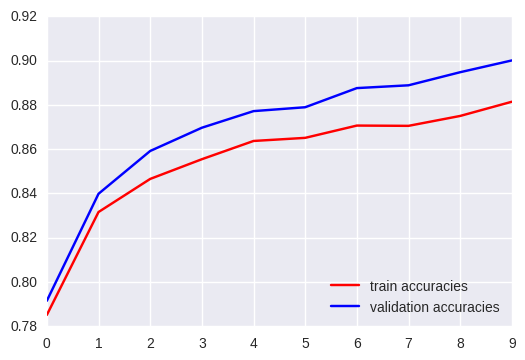

In [33]:
plt.plot(range(EPOCHS), val_accuracies, 'r-',
        range(EPOCHS), train_accuracies, 'b-')
        #range(EPOCHS), test_accuracies, 'g-')
        #range(EPOCHS), (list(np.array(val_accuracies) - np.array(train_accuracies))), 'g-')
#plt.plot(train_accuracies)
plt.legend(["train accuracies","validation accuracies"],loc='lower right')
plt.show()

In [26]:
print("Training:\n")
for i, a in enumerate(train_accuracies):
    print("{}: {:.4f}".format(i,a))
    
print("Validation:\n")
for i, a in enumerate(val_accuracies):
    print("{}: {:.4f}".format(i,a))
    
print("Test:\n")
for i, a in enumerate(test_accuracies):
    print("{}: {:.4f}".format(i,a))

Training:

0: 0.7915
1: 0.8398
2: 0.8592
3: 0.8697
4: 0.8772
5: 0.8789
6: 0.8876
7: 0.8888
8: 0.8947
9: 0.9001
Validation:

0: 0.7851
1: 0.8316
2: 0.8465
3: 0.8554
4: 0.8637
5: 0.8651
6: 0.8706
7: 0.8705
8: 0.8750
9: 0.8814
Test:

0: 0.7735
1: 0.8094
2: 0.8220
3: 0.8309
4: 0.8347
5: 0.8322
6: 0.8404
7: 0.8385
8: 0.8414
9: 0.8435


In [27]:
try:
    saver
except NameError:
    saver = tf.train.Saver()

with tf.Session() as sess:   
    #sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('foo.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_loss, test_acc = eval_data(X_test, y_test)
    print("Test loss = {:.3f}".format(test_loss))
    print("Test accuracy = {:.3f}".format(test_acc))

    predicted_classes = np.array(prediction_in_batches(X_test))

Test loss = 0.526
Test accuracy = 0.844


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    if not normalize:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1525   39   16   20   13    7   55   17    9   43]
 [  84 4592   40   51  147   16   15  120   24   10]
 [  18   90 3626   99   64   35   14  135   24   44]
 [  22  104   78 2238   44   92   47   35   81  141]
 [  32   96   53   48 2194   10   27   26    6   31]
 [   9   25   27  130   31 1974  136   10   14   28]
 [  66   39    9   52   52   82 1600   17   42   18]
 [  15  127   53   34   10   13    9 1747    6    5]
 [  45   19   26   93   42   50  132    8 1180   65]
 [  80   28   70   31   20   21   21   27   15 1282]]


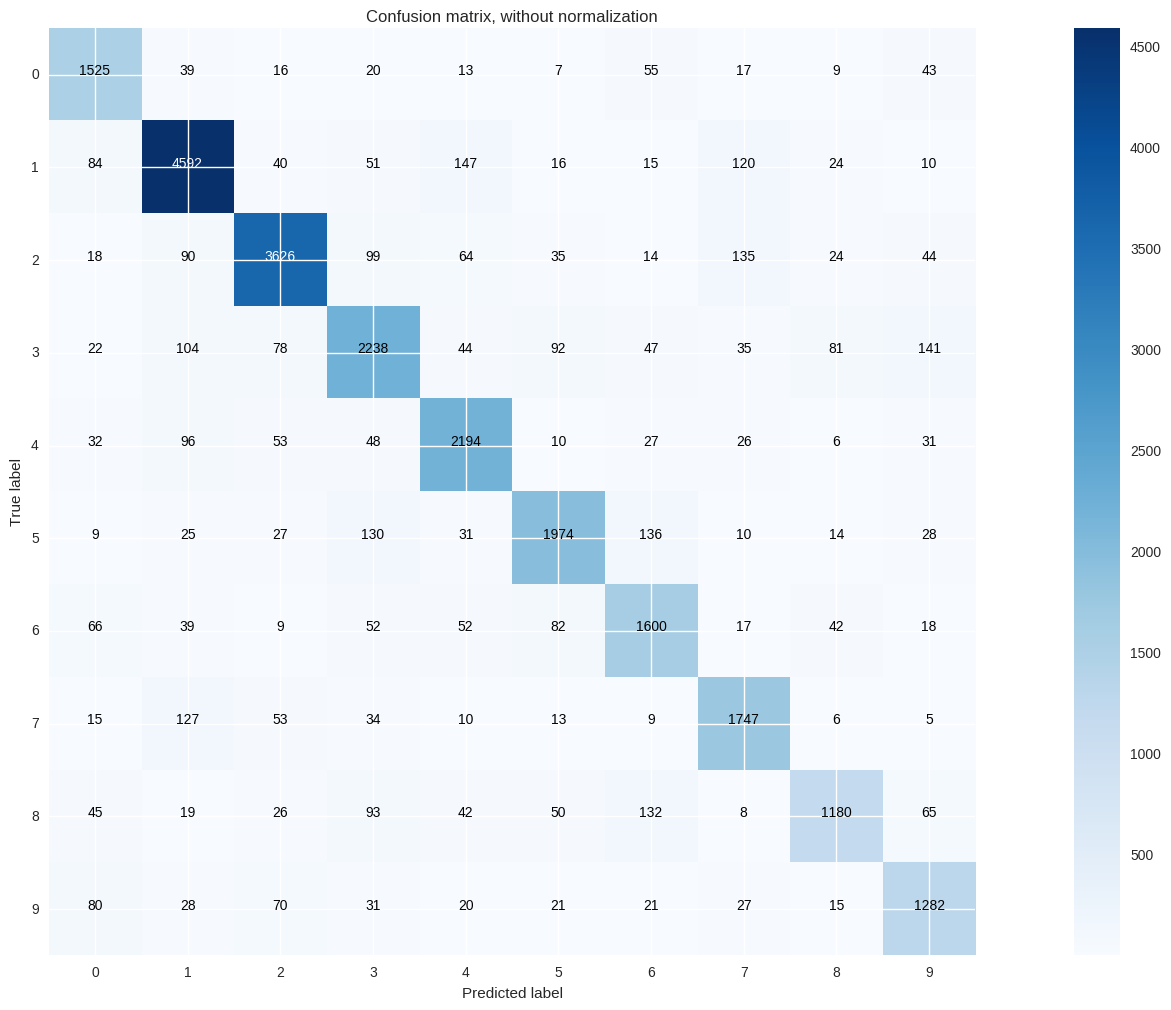

In [29]:
# Create Confusion Matrix
cnf_matrix = confusion_matrix(y_test_classes, predicted_classes)

# Plot Confusion Matrix
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))

#Plot with Number
plot_confusion_matrix(cnf_matrix,classes=range(n_classes),
                      title='Confusion matrix, without normalization')

plt.show()


### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_



## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


In [30]:
index_five = [142, 1542, 2842, 3024, 4442]
test_five = X_test[index_five]
sess = tf.Session()

predicted_classes = []

with tf.Session() as sess:    
    new_saver = tf.train.import_meta_graph('foo.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
       
    predicted_classes = sess.run(predictions, feed_dict={x: test_five, keep_prob: 1.0})

In [1]:
f, ax = plt.subplots(len(index_five), 1, figsize=(12.0, 25.0))
f.subplots_adjust(hspace=.5)
for i, idx in enumerate(index_five):    
    #Plot Image
    ax[i].imshow(X_test[idx])
    ax[i].set_title("{} \n Predicted Class: {} \n Real Class: {}".format(index_five[i], predicted_classes[i], y_test_classes[idx]))
 
 
plt.plot()


NameError: name 'plt' is not defined

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_


## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_


### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_


### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_


-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?